# Introduction to EDA Notebook

"""
### Notebook Objective

This notebook aims to perform Exploratory Data Analysis (EDA) on a dataset containing text from Stormfront, a white supremacist forum. The goal is to understand its characteristics and identify necessary preprocessing steps for model training.

### Data Overview

The dataset contains posts from various subforums that have been split into sentences. These sentences are manually labeled for hate speech. For more details, refer to the article available [here](https://www.aclweb.org/anthology/W18-51.pdf) (page 25 onward).

### Dataset Files

1. **all_files**: Contains all forum posts, with each file representing a sentence. File names are in the format `commentID_sentenceNumber.txt`.
2. **sampled_train**: Balanced set of labeled sentences used for training.
3. **sampled_test**: Balanced set of labeled sentences used for testing.
4. **annotations_metadata.csv**: Contains labels, context needs, user IDs, and subforum IDs.

### Hate Speech Definition

The paper defines hate speech as: 
    "any communication that disparages a target group of people based on some characteristic such as race, color, ethnicity, gender, sexual orientation, nationality, religion, or other characteristic."

### Notebook Structure

1. **Setup**
   - Import libraries, set random seed, and define data paths.
2. **Data Loading**
   - Load datasets and display initial rows.
3. **Data Exploration**
   - **Overview**: Data types, missing values, statistics, distributions.
   - **Label Distribution**: Balance between classes.
   - **Text Length Analysis**: Comment length distributions.
   - **Word Frequency Analysis**: Common words.
   - **Subforum Analysis**: Tendencies towards hate speech.
   - **User Analysis**: Post frequency and hate speech ratio.
   - **Context Need Analysis**: Frequency of additional context requirement.
4. **Text Data**
   - Clean text.
5. **Export Cleaned Data**
   - Save processed data for model training.
"""


# Setup

In [1]:
import pandas as pd 
import os
import glob
import numpy as np 
import random
from cleantext.sklearn import CleanTransformer
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import sweetviz as sv


# Set a random seed for reproducibility
random.seed(42)


In [2]:
metadata_path = "../data/annotations_metadata.csv"
all_files_path = "../data/all_files"
sampled_test_path = "../data/sampled_test"
sampled_train_path = "../data/sampled_train"


# Importing data 

In [3]:
def read_files_in_directory(directory_path):
    """
    Reads all text files in the specified directory and extracts content along with file metadata.

    Args:
    directory_path (str): The path to the directory containing text files.

    Returns:
    df (pd.DataFrame): DataFrame containing file_id and text
    """
    # List all txt files in the specified directory
    all_files_list = glob.glob(os.path.join(directory_path, '*.txt'))
    
    # Initialize a list to store the content and metadata
    all_files_data = []
    
    # Read each file and store the contents along with the file name information
    for file_path in all_files_list:
        with open(file_path, 'r', encoding='utf-8') as file:
            # Extract file name without the directory path and extension
            file_name = os.path.basename(file_path).split('.')[0]
            # Split the file name to get comment ID and sentence number
            all_files_data.append((file_name, file.read()))
        
    # Create a DataFrame from the collected data
    df = pd.DataFrame(all_files_data, columns=['file_id', 'text'])
    
    # display the first few rows of the DataFrame
    print(df.shape)
    display(df.head(3))
    return df


In [4]:
df_metadata = pd.read_csv(metadata_path)
display(df_metadata.shape)
df_metadata.head(1)

(10944, 5)

,file_id,user_id,subforum_id,num_contexts,label
0,12834217_1,572066,1346,0,noHate


In [5]:
df_all_files = read_files_in_directory(all_files_path)

(10944, 2)


,file_id,text
0,13458115_2,It 's like that at most public boards .
1,13367480_1,I wonder if one of the victims opened the door...
2,30422449_1,Some people believe the Jack O ' Lantern also ...


In [6]:
df_sampled_test = read_files_in_directory(sampled_test_path)

(478, 2)


,file_id,text
0,30399453_2,I can give you her Skype and she will answer a...
1,13456898_1,"I know exactly what you 're saying , I just ha..."
2,13605248_8,"Norway : 3.3 ( 2001 ) , 3.9 ( 2002 ) , 3.5 ( 2..."


In [7]:
df_sampled_train = read_files_in_directory(sampled_train_path)

(1914, 2)


,file_id,text
0,14651837_4,Ready .... GO !!!
1,31713873_1,If i sent you some pic wound use be able to pu...
2,30586609_1,ALWAYS SPEAK OUT WHEN IN A CLASS WITH A BRAINW...


Let's make sure that the sampled datasets are a subset of the all files 

In [8]:
# Check if the sampled datasets are subsets of the all_files dataset
test_in_all = df_sampled_test['file_id'].isin(df_all_files['file_id']).all()
train_in_all = df_sampled_train['file_id'].isin(df_all_files['file_id']).all()

print("All test samples are in all_files:", test_in_all)
print("All train samples are in all_files:", train_in_all)


All test samples are in all_files: True
All train samples are in all_files: True


To start with, we are not only going to focus on the sampled_train and sampled_test datasets, but on the all_files dataset. The subsets were generated as a way to deal with the fact that the classes are unbalanced. But we are going to try to deal with this problem in a different way, ideally benefiting from the entire dataset.

### Merging text with metadata 

In [9]:
df = df_metadata.merge(df_all_files, on='file_id', how='inner')
display(df.shape)
df.head(3)

(10944, 6)

,file_id,user_id,subforum_id,num_contexts,label,text
0,12834217_1,572066,1346,0,noHate,"As of March 13th , 2014 , the booklet had been..."
1,12834217_2,572066,1346,0,noHate,In order to help increase the booklets downloa...
2,12834217_3,572066,1346,0,noHate,( Simply copy and paste the following text int...


In [10]:
df[["comment_id", "sentence_number"]]= df['file_id'].str.split('_', expand=True)
display(df.shape)
df.head(3)

(10944, 8)

,file_id,user_id,subforum_id,num_contexts,label,text,comment_id,sentence_number
0,12834217_1,572066,1346,0,noHate,"As of March 13th , 2014 , the booklet had been...",12834217,1
1,12834217_2,572066,1346,0,noHate,In order to help increase the booklets downloa...,12834217,2
2,12834217_3,572066,1346,0,noHate,( Simply copy and paste the following text int...,12834217,3


# Data Overview  

In [11]:
# Assign appropiate types according to the data in each column
df = df.astype({
    'file_id': 'str',
    'user_id': 'str',
    'subforum_id': 'str',
    'num_contexts': 'int',
    'label': 'category',
    'text': 'str',
    'comment_id': 'str',
    'sentence_number': 'int'
})


In [12]:
df.describe(include="all", percentiles=[.25, .50, .75, .90, .95, .99])


,file_id,user_id,subforum_id,num_contexts,label,text,comment_id,sentence_number
count,10944,10944,10944,10944.000000,10944,10944,10944,10944.000000
unique,10944,2792,21,NaN,4,10760,5000,NaN
top,12834217_1,572043,1362,NaN,noHate,2508,14098769,NaN
freq,1,248,868,NaN,9507,21,24,NaN
mean,NaN,NaN,NaN,0.229349,NaN,NaN,NaN,2.187409
std,NaN,NaN,NaN,1.121689,NaN,NaN,NaN,1.986812
min,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,2.000000
75%,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,2.000000


From the table above, we can observe the following:

  - Each `file_id` is unique.  

  - There are 2,792 distinct `user_id`.  

  - The dataset encompasses 21 subforums. The majority of entries have a `num_contexts` value of zero, while approximately 5% of the data points have more than one context, with the maximum reaching 32.  

  - There are four distinct `label` classes.

  - Some text entries are duplicated, which could potentially lead to data leakage. We will investigate whether these duplicated `text` entries correspond to the same `label`.  

  - There are 5000 `comment_id` in the dataset. With an average of slightly over 2 sentences per comments and a max of 24 sentences.
  
  - There are no missing values in the dataset.


Now we are going to focus on some of these details to better understand the data.


### Label Distribution

Let's start looking at the distribution for the different label classes.

In [13]:
df['label'].value_counts(normalize=True)

label
noHate      0.868695
hate        0.109284
relation    0.015351
idk/skip    0.006670
Name: proportion, dtype: float64

In [14]:
# Let's look at some examples for each class 
for label in df['label'].unique():
    print(f"Examples for label: {label}")
    print("\n")
    display(df.loc[df['label'] == label, 'text'].head(10).tolist())
    print("\n\n")


Examples for label: noHate




['As of March 13th , 2014 , the booklet had been downloaded over 18,300 times and counting .',
 'In order to help increase the booklets downloads , it would be great if all Stormfronters who had YouTube accounts , could display the following text in the description boxes of their uploaded YouTube videos .',
 '( Simply copy and paste the following text into your YouTube videos description boxes. )',
 "Click on the `` DOWNLOAD ( 7.42 MB ) '' green banner link .",
 'Booklet updated on Feb. 14th , 2014 .',
 '( Now with over 18,300 Downloads. )',
 "PDF file : http://www.mediafire.com/download/7p3p3goadvvqvsf/WNDebateBooklet_2-14-14.pdfMSWordfile:http://www.mediafire.com/download/psezkkk4d6a3wt1/WNDebateBooklet _ 2-14-14.docx Watch the 10 hour video version of `` The Zionist Attack on Western Civilization '' @ http://trutube.tv/video/14247/The-Zionist-Attack-on-Western-Civilization-Pages-1-33-Part-1-of-4-Banned-from-YouTubeNotepadPromotionalYouTubeComment:http://www.mediafire.com/download/96




Examples for label: hate




['Click below for a FREE download of a colorfully illustrated 132 page e-book on the Zionist-engineered INTENTIONAL destruction of Western civilization .',
 "She may or may not be a Jew but she 's certainly stupid , she seems to think the Blacks wo n't kill her alongside every other White they can get their dirty hands on , what a muppet !",
 "I 've always considered teaching as one of the professions I would like to get into , but not in a neighbourhood like that ... never. kids like that disgust me .",
 'And the sad thing is the white students at those schools will act like that too .',
 "Their gods often had pale skin and blue eyes but I suppose literacy is n't valued highly by their cultural intelligencia .",
 'Greece need a man like Adolf Hitler and now is the perfect time to start a national political movement to free Your country from the zionist bankers',
 'He is a pathetic little chimp .',
 'Try El Paso Texas Soo much mudd invasion that the river is the same color as those pla




Examples for label: idk/skip




['Glædelig jul !',
 "Det er forresten en ting til Órkneyjar vil si deg , `` Tack så mycket . ''",
 'Jag har inte själv varit med någon gång men jag har stor respekt för de som deltar .',
 'Suomalainen totta kai !',
 'ApÃ © ro gÃ © ant : trois jeunes soupÃ § onnÃ © s de viol https : //www.stormfront.org/forum/t809905/',
 'BaoFeng 左眼技术 采用左眼专利技术 利用cpu和gpu有效提升画质 在线高清 shd专利技术 , 1m带宽 流畅播放720p高清视频 3d技术',
 'Sørensen , 19 år , er født 8. april 1982 i Kolding .',
 'Har taget en HH-eksamen på handelsskolen i Nyborg .',
 'Medlem af DFUìs bestyrelse .',
 'I sin fritid går Karina Sørensen på jagt med sin far , dyrker styrketræning eller nyder tilværelsen med sin kæreste .']




Examples for label: relation




['You are telling me that 78 % of kids under 6 in Frankfurt are all foreigners ?',
 'Jeeze its worst than the UK .',
 "So far today I 've come across the words scum , slut and bitch .",
 'All too describe my sisters .',
 'The Indian teenager was showing the Caucasian American girl how to dissolve cow dung in water , and then use a broom to spread the filth all over the floor of their house .',
 "Certain cultural practices just tell you volumes about a people , do n't they ?",
 'Here is my old school picture i think it was in 1994 .',
 'I hope such classes will be the future of all Russia',
 'No doubt the bulk of her votes came from the ever growing chinese immigrant community around Belfast .',
 'Scum .']

After a quick look at the different labels, we can observe the following:

- The label `idk/skip` represent a small fraction of the values (around 0.7%). As described in the paper they are a mix of weird characters and text in non-English languages. In real life scenarios different languages or weird characters can appear, and in the model should be able to assign them to the correct class (hate versus no hate). Ideally I would like to have the appropiate label for them (we could use machine translation or a zero/ few-shot learning approach to label them). 

Given the scope of this project and the small fraction of data it represents, we are going to drop the datapoints with the `idk/skip` label. 

 

- The label `relation` is also a small fraction of the values (around 1.5%). According to the paper, _"the `relation` label is given separately to all the sentences that need each other to be understood as hate speech. That is, consecutive sentences with this label convey hate speech but depend on each other to be correctly interpreted."_ 

In order to be able to use the datapoints with the label `relation`, we are going to aggregate the information into a comment level. 



In [15]:
# Dropping Skip
df = df[df["label"].isin(["hate", "noHate", "relation"])].reset_index(drop=True)
display(df.shape)


(10871, 8)

In [16]:
# Aggregating the data at the comment level
df_comment = df.groupby(['comment_id', 'user_id', 'subforum_id']).agg({
    'text': '\n'.join,
    'label': lambda x: not all(x == 'noHate'),
    'num_contexts': 'max'
}).reset_index()
display(df_comment.shape)
df_comment.head(3)


(4998, 6)

,comment_id,user_id,subforum_id,text,label,num_contexts
0,12834217,572066,1346,"As of March 13th , 2014 , the booklet had been...",True,0
1,12834278,572066,1346,"As of December 31st , 2013 at about 8 AM PST ,...",True,0
2,12834493,572058,1396,She may or may not be a Jew but she 's certain...,True,0


When we look at the problem at a comment level, the classes are a bit more balanced.

In [17]:
# Label distribution at Text level 
df["label"].value_counts(normalize=True)

label
noHate      0.874529
hate        0.110017
relation    0.015454
idk/skip    0.000000
Name: proportion, dtype: float64

In [18]:
# Label distribution at Comment level 
df_comment["label"].value_counts(normalize=True)

label
False    0.785314
True     0.214686
Name: proportion, dtype: float64

Now that we have a boolen label, we can use this profiler to get a better understanding of the data.

In [19]:
report = sv.analyze(df_comment, target_feat='label')
report.show_html("profile_report.html") # saving this report as an HTML file


                                             |          | [  0%]   00:00 -> (? left)

Report profile_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Let's now look at the lenght of the comments

<Axes: title={'center': 'Comment Length Distribution (#\xa0characters)'}, ylabel='Frequency'>

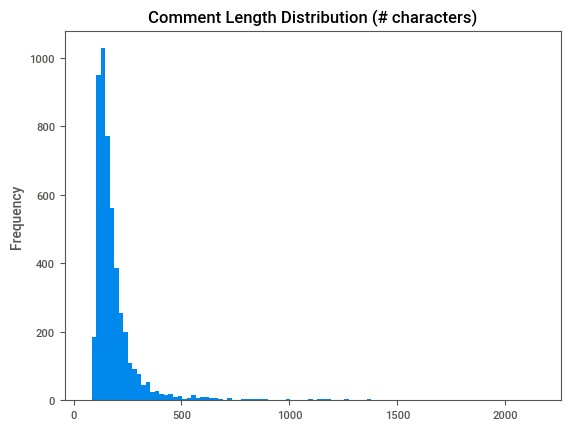

In [20]:
df_comment['text'].map(len).plot(kind='hist', bins=100, title='Comment Length Distribution (# characters)')

Most of the comments have less than 500 characters. So the comment length should not be a problem for the king of model we are planning to use. )

### SubForum 

Let's now look at the Subforum to understand if there is some signal in this variable that the model can use to predict hate speech.

In [21]:
df_comment.groupby(['subforum_id'])['label'].agg(['mean', 'count']).sort_values("mean", ascending=False)


,mean,count
subforum_id,,
1371,0.352159,301
1345,0.344538,357
1346,0.318644,295
1391,0.287709,358
1388,0.269076,249
1387,0.243590,312
1347,0.242152,223
1396,0.232877,73
1354,0.224044,183


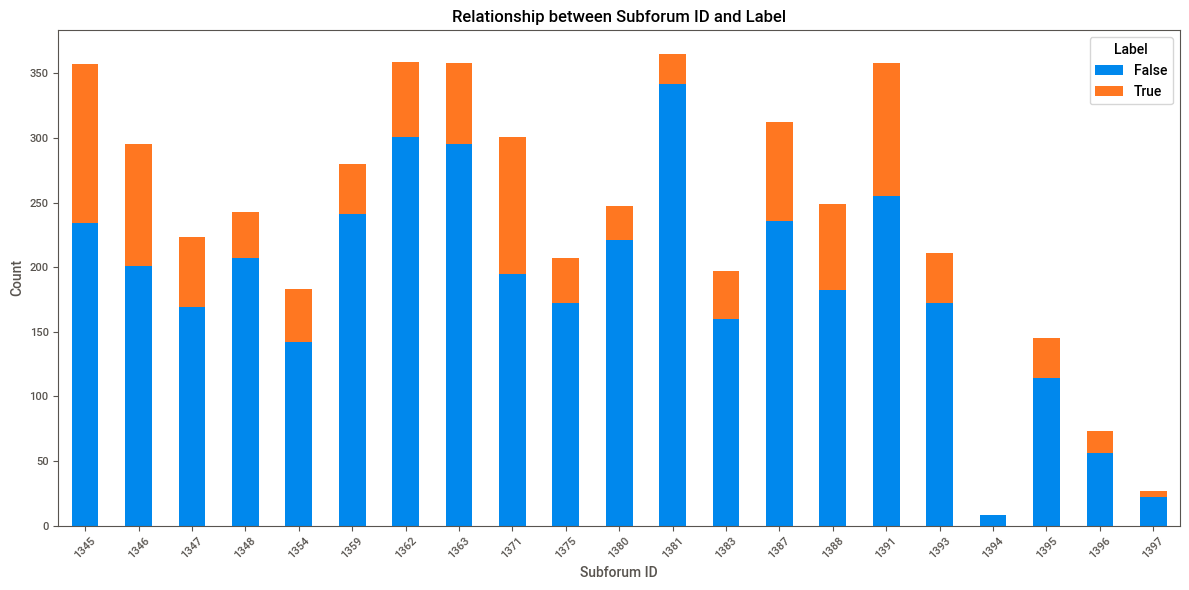

In [22]:
# Analyzing the relationship between 'subforum_id' and 'label' using a stacked bar chart for clearer comparison
subforum_label_counts = df_comment.groupby(['subforum_id', 'label']).size().unstack(fill_value=0)
subforum_label_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Relationship between Subforum ID and Label')
plt.xlabel('Subforum ID')
plt.ylabel('Count')
plt.legend(title='Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


As stated in the paper, it appears that the probability distribution of hate speech varies significantly across different subforums. Since some of them are more related to topics where hate speech is more lilely to appear. Therefore this feature is a potential candidate to be used as a feauture for the model.

Ultimately, the decision to include subforum as a model feature should be discussed with stakeholders, especially considering the model's intended application. In our case, as we are building a generic hate speech detector, we are not going to be able to leverage this information.


### Users 

Let's now have a look at the `user_id` variable 

In [23]:
df_comment['user_id'].nunique()

2791

<Axes: title={'center': 'User Comment Count Distribution'}, ylabel='Frequency'>

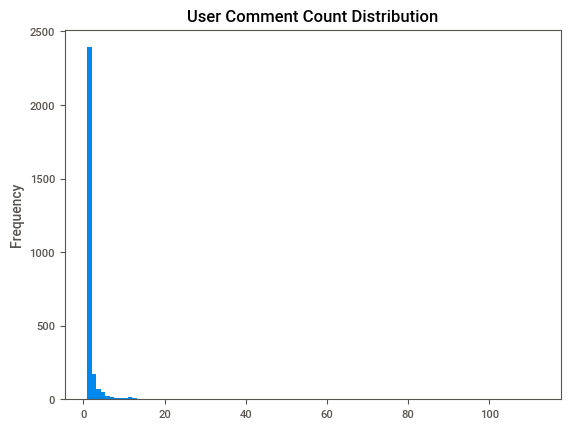

In [24]:
df_comment['user_id'].value_counts().plot(kind='hist', bins=100, title='User Comment Count Distribution')


In [25]:
df_comment.groupby(['user_id'])['label'].agg(['mean', 'count']).sort_values("count", ascending=False).head(10)


,mean,count
user_id,,
572043,0.187500,112
576945,0.058824,34
572266,0.242424,33
575695,0.133333,30
572095,0.000000,28
574600,0.000000,17
579630,0.187500,16
577743,0.000000,16
577166,0.000000,15


Given the large number of users and the relatively low message volume per user, we will not utilize this feature in our model. 
However, again depending on the purpose there may be scenarios where incorporating it could be beneficial.



### num_contexts

<Axes: xlabel='num_contexts'>

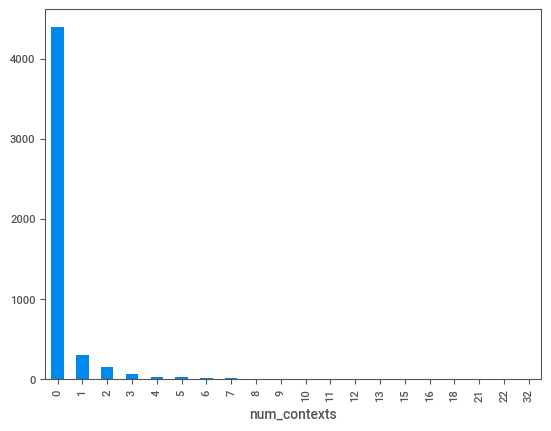

In [26]:
df_comment['num_contexts'].value_counts().sort_index().plot(kind='bar')

Most of the comments do not require further context.

Unfortunately, there is no much we can do to improve this. We can expect that this number reduces a bit since we are no longer only looking at text level  but at comment one. 

Also, since we are going to use some pre-training embeddings, we can expect that somehow this context can be included in the world-model that generated the embeddings.


# Dealing with Unbalanced Classes 

<Axes: xlabel='label'>

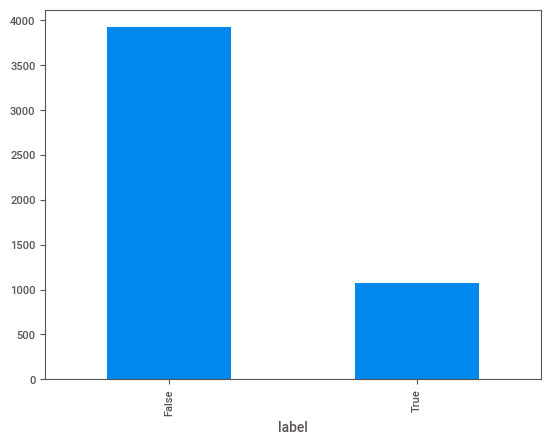

In [27]:
df_comment['label'].value_counts().plot(kind='bar')

There are a bunch of techniques that we could use to deal with the unbalanced classes. Here I list a few:  
 - Resampling Techniques: Different methods like Oversampling, Undersampling  
 - Modify Class Weights: Penalize misclassifications of the minority class or incorporate the cost of misclassification into the training process.  
 - Generate Synthetic Samples: Use LLMs to generate synthetic samples given some examples, or more traditional synthetic oversampling techniques such as Synthetic SMOTE (after converting text to some sort of numeric representation)

However, we are not going to use any of those. We are going to keep the unbalance as it is, and later during the training we'll try to use methods that are robust against unbalanced classes.
     

## Text 

As we can see the text contains URL, some special characters among other things. We could build a customized system to clean the text according with the issues that we find in the data we have. 

However, in the benefit of time we are going to use a generic cleaning pipeline to clean the text.

In [28]:
df_comment["text"].sample(10).tolist()

['I would think most girls would like to dress and look nice for their man anyways .\nSo he can show her off like a brand new sparkly jewel etc etc .',
 "I've posted a thread in Stormfront Latin to help spread the WNPS and too see if we can get more translations .",
 "Look at this cultural incongruity from Plymouth . VIDEO : Plymouth celebrates St George 's Day with music and dancing in the streets | This is Plymouth",
 'Just for the record is this the same Journalist that wrote the article a few weeks ago telling us to mongrelise ?',
 'Some kid knocking on a blacks door and running away.Look donkeys fords chipie across the road the internet cafe run by black overeactcted.Attacked the Limerick kid all at least 20 of them.Kid arrived out later with his at least 30 friends.The owner of internet cafe says to the white youth i have white blood.One roars back the only thing white about you is your teeth .',
 "Another reason it might say so in the Census is because whites like me refused to 

These are the parameters we are going to use for the text cleaning

In [29]:
cleaner = CleanTransformer(
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=False,                     # lowercase text
    no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
    no_urls=True,                  # replace all URLs with a special token
    no_emails=True,                # replace all email addresses with a special token
    no_phone_numbers=True,         # replace all phone numbers with a special token
    no_numbers=True,               # replace all numbers with a special token
    no_digits=True,                # replace all digits with a special token
    no_currency_symbols=True,      # replace all currency symbols with a special token
    no_punct=True,                 # remove punctuations
    replace_with_punct="",          # instead of removing punctuations you may replace them
    replace_with_url="<URL>",
    replace_with_email="<EMAIL>",
    replace_with_phone_number="<PHONE>",
    replace_with_number="<NUMBER>",
    replace_with_digit="0",
    replace_with_currency_symbol="<CUR>",
    lang="en"                       # set to 'de' for German special handling
)

Here we can see some examples after cleaning the text data:

In [30]:
df_comment["text"].head(3).tolist()

["As of March 13th , 2014 , the booklet had been downloaded over 18,300 times and counting .\nIn order to help increase the booklets downloads , it would be great if all Stormfronters who had YouTube accounts , could display the following text in the description boxes of their uploaded YouTube videos .\n( Simply copy and paste the following text into your YouTube videos description boxes. )\nClick below for a FREE download of a colorfully illustrated 132 page e-book on the Zionist-engineered INTENTIONAL destruction of Western civilization .\nClick on the `` DOWNLOAD ( 7.42 MB ) '' green banner link .\nBooklet updated on Feb. 14th , 2014 .\n( Now with over 18,300 Downloads. )\nPDF file : http://www.mediafire.com/download/7p3p3goadvvqvsf/WNDebateBooklet_2-14-14.pdfMSWordfile:http://www.mediafire.com/download/psezkkk4d6a3wt1/WNDebateBooklet _ 2-14-14.docx Watch the 10 hour video version of `` The Zionist Attack on Western Civilization '' @ http://trutube.tv/video/14247/The-Zionist-Attack-

Or after cleaning the text:

In [31]:
cleaner.transform(df_comment["text"].head(3).tolist())

['As of March 00th <NUMBER> the booklet had been downloaded over <NUMBER> times and counting\nIn order to help increase the booklets downloads it would be great if all Stormfronters who had YouTube accounts could display the following text in the description boxes of their uploaded YouTube videos\nSimply copy and paste the following text into your YouTube videos description boxes\nClick below for a FREE download of a colorfully illustrated <NUMBER> page ebook on the Zionistengineered INTENTIONAL destruction of Western civilization\nClick on the DOWNLOAD <NUMBER> MB green banner link\nBooklet updated on Feb 00th <NUMBER>\nNow with over <NUMBER> Downloads\nPDF file <URL> <NUMBER><NUMBER><NUMBER>docx Watch the <NUMBER> hour video version of The Zionist Attack on Western Civilization <URL> White YT Comment Hyperlinked txt <URL> HyperlinkedBackUp 0Dtxt <URL> v = 0hg000ALpM Are you interested in helping spread the booklet download link across the world\nThen why not simply copy this text lin

In [32]:
df_comment["text"] = cleaner.transform(df_comment["text"].tolist())


# Save the cleaned data

With this we conclude the EDA analysis, we now have the data in a way that we can use it for training a model. 

We are going to save the data divided into train and test datasets. with a 80 - 20% split.

We'll make sure that the proportions on 'label' and 'subforum_id' are the same in both datasets. 

In [33]:
# Splitting the dataframe into train and test sets while maintaining the proportion of 'label' and 'subforum_id'
df_train, df_test = train_test_split(df_comment, test_size=0.2, stratify=df_comment[['label', 'subforum_id']])

# save the train and test dataframes to disk
df_train.to_parquet("../data/train.parquet")
df_test.to_parquet("../data/test.parquet")
